# Modeling the Fire Data for Fires Over 1 Acre and Lasting Longer than 24 Hours But With Outliers Removed

## The Methodology for this notebook:
1. Read in data
2. Filter out outliers
3. Examine correlation
4. Investigate clustering with DBSCAN (if successful, cluster labels will be an added feature)
5. Create the train/test dataset without the categorical feature
6. Create the train/test dataset with the categorical feature dummied
7. Create the train/test dataset with the categorical feature dummied but transformed by PCA
8. Create the train/test dataset without the categorical feature but transformed by Polynomial Features and then transformed by PCA
9. Export these 4 train/test sets for use in Neural Net investigation
10. Investigate the baseline Linear Regression Models for each of the 4 train/test sets
11. Define the helper function used to gridsearch through different models and return RMSE and R-Squared for the training and test sets
12. Use the helper function for a variety of simple models (KNN Regressor, Lasso, etc.)
13. Run a few ensemble models to see if they would be worth gridsearching through
14. Gridsearch through the best ensemble model
15. Find the best model
16. Generate predictions and compare to true values for Post-Model Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import DBSCAN

In [2]:
np.random.seed(42)

df = pd.read_csv('../../data/processed/master_dataset.csv')

df.head()

,sum_rain,sum_snow,DiscoveryAcres,total_acres,temp_2m,temp_2m_max,humidity,rain,wind_speed_2m,wind_speed_2m_max,wind_speed_10m,wind_speed_10m_max,surface_soil_wetness_5cm_below,surface_soil_wetness_to_bedrock,landcover_class
0,158.20,2.64,5.0,5990.90,24.80,33.19,5.92,0.00,1.76,3.42,2.61,4.52,0.31,0.37,489
1,10.54,0.00,1.0,136.00,22.72,31.95,2.69,0.00,2.65,4.88,3.88,6.57,0.12,0.42,470
2,152.93,2.64,15.0,147.00,26.21,35.48,7.57,0.01,1.62,4.30,2.66,6.88,0.29,0.38,183
3,284.77,7.83,1.0,2.88,-0.55,3.97,2.14,0.00,0.06,0.10,5.79,7.85,0.63,0.62,163
4,395.50,4.62,0.1,13.10,22.30,32.40,8.00,0.00,0.16,0.45,1.83,3.48,0.40,0.48,301


In [3]:
for i in df.columns:
    print(i)

sum_rain
sum_snow
DiscoveryAcres
total_acres
temp_2m
temp_2m_max
humidity
rain
wind_speed_2m
wind_speed_2m_max
wind_speed_10m
wind_speed_10m_max
surface_soil_wetness_5cm_below
surface_soil_wetness_to_bedrock
landcover_class


In [4]:
df.shape

(2122, 15)

In [5]:
df['total_acres'].describe()

count      2122.000000
mean       2999.687916
std       21287.395283
min           1.170000
25%           4.600000
50%          19.100000
75%         158.950000
max      413718.000000
Name: total_acres, dtype: float64

In [6]:
iqr = 158.95-4.6
upper_range = 1.5*iqr + 158.95
df = df[df['total_acres'] <= upper_range]

In [7]:
df.shape

(1724, 15)

---
######
### Investigating Clustering:
######
##### Using DBSCAN and Potentially Adding Cluster Results as Feature
######
___

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'total_acres'), df['total_acres'], random_state= 42)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [9]:
# Checking to see which value of epsilon is best

silhouette_score_list = []
epsilons = np.linspace(1, 10, 20)

for i in epsilons:
    try:
        dbscan = DBSCAN(eps=i)
        dbscan.fit(X_train)
        silhouette_score_list.append([silhouette_score(X_train, dbscan.labels_), i])
    except:
        pass
silhouette_score_list

[[-0.3602412959172937, 1.0],
 [-0.27127586688691074, 1.4736842105263157],
 [0.25630971921938606, 1.9473684210526314],
 [0.38298188987525206, 2.4210526315789473],
 [0.49147603827925496, 2.894736842105263],
 [0.5008692311004035, 3.3684210526315788],
 [0.5456956757682443, 3.8421052631578947],
 [0.5795107952760772, 4.315789473684211],
 [0.679444527582705, 4.789473684210526],
 [0.7300696979411784, 5.263157894736842],
 [0.7300696979411784, 5.7368421052631575],
 [0.7300696979411784, 6.2105263157894735],
 [0.8004412350233295, 6.684210526315789],
 [0.8004412350233295, 7.157894736842105],
 [0.8004412350233295, 7.63157894736842],
 [0.8004412350233295, 8.105263157894736],
 [0.8004412350233295, 8.578947368421051],
 [0.8004412350233295, 9.052631578947368],
 [0.8004412350233295, 9.526315789473683],
 [0.8004412350233295, 10.0]]

In [10]:
#checking to see 
silhouette_score_list = []
min_samples = range(1, 21)

for j in min_samples:
    try:
        dbscan = DBSCAN(eps= 6.47, min_samples = j)
        dbscan.fit(X_train)
        silhouette_score_list.append([silhouette_score(X_train, dbscan.labels_), j])
    except:
        pass
silhouette_score_list

[[0.8004412350233295, 1],
 [0.8004412350233295, 2],
 [0.8004412350233295, 3],
 [0.8004412350233295, 4],
 [0.8004412350233295, 5],
 [0.8004412350233295, 6],
 [0.8004412350233295, 7],
 [0.8004412350233295, 8],
 [0.8004412350233295, 9],
 [0.8004412350233295, 10],
 [0.8004412350233295, 11],
 [0.8004412350233295, 12],
 [0.7300696979411784, 13],
 [0.7300696979411784, 14],
 [0.7300696979411784, 15],
 [0.7300696979411784, 16],
 [0.7300696979411784, 17],
 [0.7300696979411784, 18],
 [0.7300696979411784, 19],
 [0.7300696979411784, 20]]

In [11]:
db = DBSCAN(eps=6.68)
db.fit(X_train)
pd.Series(db.labels_).unique()

array([ 0, -1], dtype=int64)

In [12]:
(db.labels_ == -1).sum()

1

Decided to not use DBSCAN

---
######
### Investigating Correlation Between the Features and Target (DailyAcres)
######
___

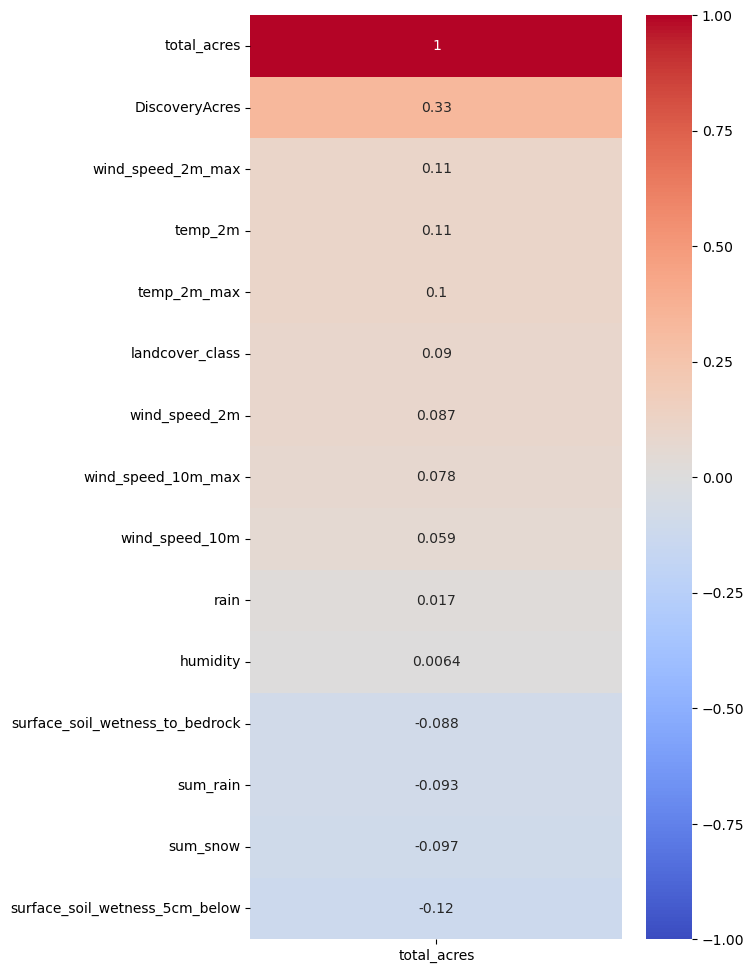

In [13]:
plt.figure(figsize = (6, 12))
sns.heatmap(df.corr()[['total_acres']].sort_values(by = 'total_acres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Train/Test Splitting Data, Standard Scaling, Polynomial Features and PCA (not using landcover_class)
######
___

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['total_acres', 'landcover_class']), df['total_acres'], random_state= 42)
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [15]:
poly = PolynomialFeatures()
poly_X_train = poly.fit_transform(X_train_sc)
poly_X_test = poly.transform(X_test_sc)

In [16]:
poly_X_train.shape

(1293, 105)

In [17]:
pca = PCA(random_state = 42)


Z_train_poly = pca.fit_transform(poly_X_train)
Z_test_poly = pca.transform(poly_X_test)

In [18]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:60], 3)

array([0.553, 0.651, 0.745, 0.808, 0.837, 0.858, 0.876, 0.894, 0.906,
       0.917, 0.925, 0.931, 0.937, 0.942, 0.947, 0.951, 0.955, 0.958,
       0.961, 0.964, 0.967, 0.969, 0.971, 0.974, 0.976, 0.977, 0.979,
       0.981, 0.982, 0.983, 0.985, 0.986, 0.987, 0.988, 0.989, 0.989,
       0.99 , 0.991, 0.992, 0.992, 0.993, 0.993, 0.994, 0.994, 0.995,
       0.995, 0.995, 0.996, 0.996, 0.996, 0.997, 0.997, 0.997, 0.997,
       0.998, 0.998, 0.998, 0.998, 0.998, 0.998])

In [19]:
Z_train_poly = Z_train_poly[:,:60]
Z_test_poly = Z_test_poly[:,:60]

In [20]:
# PCA X_train without Polynomial Feature transformation
pca = PCA(random_state = 42)


Z_train = pca.fit_transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [21]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:12], 3)

array([0.333, 0.557, 0.679, 0.769, 0.846, 0.906, 0.937, 0.964, 0.98 ,
       0.991, 0.999, 1.   ])

In [22]:
Z_train = Z_train[:,:12]
Z_test = Z_test[:,:12]

---
######
### Dummying Landcover_Class and re-train/test splitting
######
___

In [23]:
df1 = pd.get_dummies(data = df, columns = ['landcover_class'], drop_first= True)
X_train_dum, X_test_dum, y_train, y_test = train_test_split(df1.drop(columns = ['total_acres']), df['total_acres'], random_state= 42)
ss = StandardScaler()
X_train_dum = ss.fit_transform(X_train_dum)
X_test_dum = ss.transform(X_test_dum)

In [77]:
#np.savetxt('../../data/processed/Neural_Net_Data/X_train_without_outliers.csv', X_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_test_without_outliers.csv', X_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_without_outliers.csv', Z_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_without_outliers.csv', Z_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_poly_without_outliers.csv', Z_train_poly, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_poly_without_outliers.csv', Z_test_poly, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_train_dummied_without_outliers.csv', X_train_dum, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_test_dummied_without_outliers.csv', X_test_dum, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_train_without_outliers.csv', y_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_test_without_outliers.csv', y_test, delimiter=',')

---
######
### Modeling / Simple Models
######
---

#### Linear Regression (Baseline) with DF without Landcover_class Dummied Columns

In [136]:
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.11707479932695453
Testing R-Squared: 0.18276676904241673
RMSE: 62.933417201762055


In [142]:
# Looking at the coefficients of one of the best models we've found
coefs = pd.DataFrame(index = X_train.columns, data = lr.coef_, columns= ['Coefficient'])
coefs

,Coefficient
sum_rain,-0.024284
sum_snow,0.509858
DiscoveryAcres,1.592272
temp_2m,2.367230
temp_2m_max,-1.318652
humidity,0.333696
rain,1.299634
wind_speed_2m,-41.718141
wind_speed_2m_max,25.131269
wind_speed_10m,23.760358


#### Linear Regression (Baseline) with DF including Landcover_class Dummied Columns

In [25]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train_dum, y_train)
print(f'Training R-Squared: {lr.score(X_train_dum, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test_dum, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test_dum), squared = False)}')

Training R-Squared: 0.19686113693084284
Testing R-Squared: -1.2354481655103512e+22
RMSE: 7737854684080.361


#### Linear Regression (Baseline) with Polynomial PCA

In [27]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train_poly, y_train)
print(f'Training R-Squared: {lr.score(Z_train_poly, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test_poly, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test_poly), squared = False)}')

Training R-Squared: 0.16205695441889467
Testing R-Squared: 0.1953926007692225
RMSE: 62.44538047448781


#### Linear Regression (Baseline) with PCA (w/o Polynomial Tranformation)

In [28]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.11046452897439385
Testing R-Squared: 0.19061004382028424
RMSE: 62.63069203984553


In [32]:
def model_eval(model, param_dict, training_data):
    '''
    This function gridsearches a model (arg: model, instantiated before function call) over the given parameters (param_dict) 
    and evalutated on the given training data (either X from DF, X_train/test_dum for dummied Landcover_class or 
    Z from PCA'd components without polynomial features and Z_train/test_poly for PCA'd components after Polynomial Features)
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        training = X_train
        testing = X_test
    elif training_data == 'X_train_dum':
        training = X_train_dum
        testing = X_test_dum
    elif training_data == 'Z_train':
        training = Z_train
        testing = Z_test
    elif training_data == 'Z_train_poly':
        training = Z_train_poly
        testing = Z_test_poly
    else:
        return "Mistaken Training Data Parameter"
    
    gs_model.fit(training, y_train)
    print(f'Best Score: {gs_model.best_score_}')
    print(f'Best Params: {gs_model.best_params_}')
    print('='*50)
    print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(testing), squared = False)}')
    print('='*50)
    print(f'Training R-Squared: {gs_model.score(training, y_train)}')
    print(f'Testing R-Squared: {gs_model.score(testing, y_test)}')

---

#### KNN Regression with DF

In [34]:
knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(10, 201, 10),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

Best Score: 0.031367700477482184
Best Params: {'n_neighbors': 60, 'weights': 'distance'}
RMSE: 66.06886360974818
Training R-Squared: 0.9987297075671161
Testing R-Squared: 0.09930642687869062


#### KNN Regression with DF and Dummies

In [33]:
knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(10, 201, 10),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train_dum')

Best Score: 0.031710478428872424
Best Params: {'n_neighbors': 70, 'weights': 'distance'}
RMSE: 68.32487268533899
Training R-Squared: 0.999987265415814
Testing R-Squared: 0.03674548763030561


#### KNN Regression with PCA Data

In [35]:
knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(10, 201, 10),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

Best Score: 0.04548860316972101
Best Params: {'n_neighbors': 60, 'weights': 'distance'}
RMSE: 65.52596644427524
Training R-Squared: 0.9987297075671161
Testing R-Squared: 0.1140478628902355


#### KNN Regression with PCA Data and Polyinomial Features

In [36]:
knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(10, 201, 10),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train_poly')

Best Score: 0.036062819203705174
Best Params: {'n_neighbors': 80, 'weights': 'distance'}
RMSE: 65.87368784043143
Training R-Squared: 0.9987298175367992
Testing R-Squared: 0.1046200918418454


---

#### Lasso Regression with DF

In [37]:
lasso = Lasso()
lasso_params = {
    'alpha': range(1, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: 0.09220712760783349
Best Params: {'alpha': 3}
RMSE: 62.45657575587876
Training R-Squared: 0.10838290037630516
Testing R-Squared: 0.19510407298253174


#### Lasso Regression with DF and Dummies

In [38]:
lasso = Lasso()
lasso_params = {
    'alpha': range(1, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train_dum')

Best Score: 0.08794250566148398
Best Params: {'alpha': 3}
RMSE: 63.128277369729574
Training R-Squared: 0.14186227155029252
Testing R-Squared: 0.1776981505553541


#### Lasso Regression with PCA

In [40]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': np.linspace(0.01, 1, 20)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: 0.08804479297528911
Best Params: {'alpha': 1.0}
RMSE: 62.585923899005145
Training R-Squared: 0.10669146327868817
Testing R-Squared: 0.1917667269769382


#### Lasso Regression with PCA and Polynomial Features

In [41]:
lasso = Lasso()
lasso_params = {
    'alpha': np.linspace(0.01, 1, 20)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train_poly')

Best Score: 0.06182526824591963
Best Params: {'alpha': 0.6352631578947369}
RMSE: 63.12066164402759
Training R-Squared: 0.15216940766252918
Testing R-Squared: 0.17789654176273295


---

#### Adaboost Regression with DF

In [104]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.008, 0.009, 0.01] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: 0.08312895003440937
Best Params: {'learning_rate': 0.009, 'n_estimators': 60}
RMSE: 62.9456797830305
Training R-Squared: 0.14655222501284038
Testing R-Squared: 0.18244826209683107


#### Adaboost Regression with DF and Dummies

In [100]:
ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.001, 0.002, 0.003] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train_dum')

Best Score: 0.07596570078999627
Best Params: {'learning_rate': 0.002, 'n_estimators': 70}
RMSE: 62.86982964516168
Training R-Squared: 0.12270274496109745
Testing R-Squared: 0.18441739008401803


#### Adaboost Regression with PCA

In [105]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.003, 0.004, 0.005, 0.006, 0.007] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: 0.0765798398217901
Best Params: {'learning_rate': 0.005, 'n_estimators': 80}
RMSE: 62.957789982011995
Training R-Squared: 0.14509467548991617
Testing R-Squared: 0.1821336522089636


#### Adaboost Regression with PCA and Polynomial Features


In [106]:
ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(20, 61, 10),
    'learning_rate': [0.008, 0.009, 0.01, 0.011] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train_poly')

Best Score: 0.06566683711252745
Best Params: {'learning_rate': 0.009, 'n_estimators': 60}
RMSE: 63.00141396381983
Training R-Squared: 0.16282690141197131
Testing R-Squared: 0.18099984660099178


---

#### RandomForest Regression with DF

In [70]:
rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(1, 10),
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'ccp_alpha': [0.01, 0.02, 0.03]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'X_train')

Best Score: 0.08283086534517729
Best Params: {'ccp_alpha': 0.01, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 3}
RMSE: 62.85449534748932
Training R-Squared: 0.12964380038056245
Testing R-Squared: 0.18481519174497885


#### RandomForest Regression with DF and Dummies

In [75]:
rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(90, 116, 5),
    'min_samples_split': [6, 7, 8],
    'min_samples_leaf': [4, 5, 6],
    'ccp_alpha': [0.03, 0.04, 0.05, 0.06, 0.07]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'X_train_dum')

Best Score: 0.06470967770001232
Best Params: {'ccp_alpha': 0.03, 'max_depth': 100, 'min_samples_leaf': 4, 'min_samples_split': 7}
RMSE: 62.758666448907846
Training R-Squared: 0.5846354045133209
Testing R-Squared: 0.18729898265767342


#### RandomForest Regression with PCA

In [76]:
rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(55, 96, 5),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [15, 16, 17],
    'ccp_alpha': [0.9, 1.0, 1.1, 1.2]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'Z_train')

Best Score: 0.07991738834655386
Best Params: {'ccp_alpha': 1.1, 'max_depth': 65, 'min_samples_leaf': 17, 'min_samples_split': 2}
RMSE: 62.555838979790195
Training R-Squared: 0.28937236414699075
Testing R-Squared: 0.19254357221545348


#### RandomForest Regression with PCA and Polynomial Features

In [74]:
rf = RandomForestRegressor(n_jobs = -1)

rf_params = {
    'max_depth': range(55, 91, 5),
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [16, 17, 18],
    'ccp_alpha': [0.5, 0.6, 0.7]
}

model_eval(model = rf,
           param_dict = rf_params,
           training_data = 'Z_train_poly')

Best Score: 0.07950666188626951
Best Params: {'ccp_alpha': 0.5, 'max_depth': 70, 'min_samples_leaf': 18, 'min_samples_split': 5}
RMSE: 62.81764067449911
Training R-Squared: 0.33896399066157856
Testing R-Squared: 0.1857708771392641


---
######
### Modeling / Ensemble Models
######
---

#### Stacking Regression with DF and with DecisionTreeRegressor Final Estimator

In [193]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -1.4184027880954284
Testing R-Squared: -1.5735150418438275
RMSE: 111.67903703281885


#### Stacking Regression with PCA and with DecisionTreeRegressor Final Estimator

In [194]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.8380928393433082
Testing R-Squared: -1.2700805059093656
RMSE: 104.8887560079958


#### Stacking Regression with DF and with LinearRegression Final Estimator

In [195]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.35317341766092314
Testing R-Squared: 0.1685160144615857
RMSE: 63.47975611894257


In [78]:
# Stacking Regressor with X_train_dum

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train_dum, y_train)

print(f'Training R-Squared: {stack.score(X_train_dum, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test_dum, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test_dum), squared = False)}')

Training R-Squared: 0.32166943127161307
Testing R-Squared: 0.1620835893436693
RMSE: 63.72482524171087


#### Stacking Regression with PCA and with LinearRegression Final Estimator

In [196]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.36721870432456305
Testing R-Squared: 0.15260315049160966
RMSE: 64.08431220679155


In [79]:
# Stacking Regressor with PCA and Polynomial Transform

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train_poly, y_train)

print(f'Training R-Squared: {stack.score(Z_train_poly, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test_poly, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test_poly), squared = False)}')

Training R-Squared: 0.39423410408209625
Testing R-Squared: 0.15329341717481437
RMSE: 64.05820621079727


#### Stacking Regression with DF and with Lasso Final Estimator

In [197]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.39146410560561584
Testing R-Squared: 0.16778479473900154
RMSE: 63.507662518737


#### Stacking Regression with PCA and with Lasso Final Estimator

In [198]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.3774795148457408
Testing R-Squared: 0.15092702302086747
RMSE: 64.14765939379238


#### Stacking Regression (different base estimators) with DF and with Lasso Final Estimator

In [199]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.15643391122638106
Testing R-Squared: 0.15881909802574934
RMSE: 63.84883935062261


#### Stacking Regression (different base estimators) with PCA and with Lasso Final Estimator

In [200]:
# Stacking Regressor with PCA

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.16276340132215728
Testing R-Squared: 0.13456852641203
RMSE: 64.76265544789085


#### Voting Regression with DF

In [201]:
#Voting Classifier with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(X_train, y_train)
print(f'Training R-Squared: {vote.score(X_train, y_train)}')
print(f'Testing R-Squared: {vote.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(X_test), squared = False)}')

Training R-Squared: 0.2933529666480559
Testing R-Squared: -0.058279572429008164
RMSE: 71.61574458739382


#### Voting Regression with PCA

In [202]:
#Voting Classifier with PCA

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: 0.4248795769435958
Testing R-Squared: 0.019913983612345643
RMSE: 68.91922758976229


---
#####
## Best Ensemble Model Thus Far - Gridsearching
#####
---

In [110]:
# To save time, each lvl1 estimator was gridsearched by itself to get best parameters for each estimator without compounding runtime
# This investigation was run with Linear regression replacing each base level estimator to see if that best simple model helped -- It remained the same

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack_params = {
    'rf__max_depth': [2],
    'rf__min_samples_split': [3],
    'rf__min_samples_leaf': [3],
    'rf__ccp_alpha': [0.03, 0.04],
    'ada__n_estimators': range(60, 67, 2),
    'ada__learning_rate': [0.01, 0.011],
    'lasso__alpha': [3]
}

model_eval(model = stack,
           param_dict = stack_params,
           training_data = 'X_train')

Best Score: 0.09632186010289094
Best Params: {'ada__learning_rate': 0.011, 'ada__n_estimators': 62, 'lasso__alpha': 3, 'rf__ccp_alpha': 0.04, 'rf__max_depth': 2, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 3}
RMSE: 62.054024241902944
Training R-Squared: 0.126111862182281
Testing R-Squared: 0.2054462312650006


---
#####
## Post Model Analysis
#####
---

In [121]:
# Running model with all gridsearched parameters
lvl1_est = ([
    ('rf', RandomForestRegressor(max_depth = 2,
                                 min_samples_leaf= 3,
                                 min_samples_split=3,
                                 ccp_alpha=0.04,
                                 n_jobs=-1)),
    ('lr', LinearRegression()),
    ('lasso', Lasso(alpha = 3))
])

stack1 = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack1.fit(X_train, y_train)

print(f'Training R-Squared: {stack1.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack1.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack1.predict(X_test), squared = False)}')

Training R-Squared: 0.13165384088997711
Testing R-Squared: 0.2045388727751749
RMSE: 62.089446124191575


In [125]:
#generating predicitons and creating a test-set dataframe
preds = stack1.predict(X_test)
test_df = X_test.copy()
test_df['total_acres'] = y_test
test_df['predicted'] = preds
test_df['predicted_minus_true'] = test_df['predicted'] - test_df['total_acres']

In [126]:
test_df.head()

,sum_rain,sum_snow,DiscoveryAcres,temp_2m,temp_2m_max,humidity,rain,wind_speed_2m,wind_speed_2m_max,wind_speed_10m,wind_speed_10m_max,surface_soil_wetness_5cm_below,surface_soil_wetness_to_bedrock,total_acres,predicted,predicted_minus_true
366,184.57,4.62,0.1,25.02,31.21,5.92,0.00,1.21,1.95,2.21,3.93,0.39,0.46,5.1,32.714156,27.614156
1332,427.15,8.32,15.0,5.42,13.22,4.46,0.39,0.81,1.39,3.92,6.30,0.55,0.54,67.8,42.938169,-24.861831
654,52.73,3.96,0.1,21.37,29.69,5.68,0.01,3.59,7.12,4.95,9.43,0.25,0.38,1.7,44.196623,42.496623
1628,14.87,0.15,1.0,36.62,44.65,5.19,0.00,2.57,4.78,3.69,5.89,0.08,0.38,6.0,59.756276,53.756276
686,305.86,10.56,1.0,19.23,28.55,6.96,1.33,1.25,2.06,2.39,4.10,0.48,0.50,7.3,27.462806,20.162806


In [144]:
# Investigating the values generated by the predictions
test_df['predicted'].describe()

count    431.000000
mean      42.233695
std       23.061547
min       16.648080
25%       33.056652
50%       38.081341
75%       45.122031
max      270.499501
Name: predicted, dtype: float64

In [143]:
# Looking at the values the predictions were off by
test_df['predicted_minus_true'].describe()

count    431.000000
mean       1.957131
std       62.130712
min     -338.195401
25%        0.718873
50%       25.304543
75%       33.464158
max       64.239538
Name: predicted_minus_true, dtype: float64

In [148]:
# Looking to see the distribution of the true values
test_df['total_acres'].describe()

count    431.000000
mean      40.276564
std       69.696780
min        1.170000
25%        4.000000
50%       10.600000
75%       40.550000
max      382.000000
Name: total_acres, dtype: float64

In [146]:
# Investigating the predicted acres for true total_acres less than 10
test_df[test_df['total_acres']<10].head(20)

,sum_rain,sum_snow,DiscoveryAcres,temp_2m,temp_2m_max,humidity,rain,wind_speed_2m,wind_speed_2m_max,wind_speed_10m,wind_speed_10m_max,surface_soil_wetness_5cm_below,surface_soil_wetness_to_bedrock,total_acres,predicted,predicted_minus_true
366,184.57,4.62,0.1,25.02,31.21,5.92,0.00,1.21,1.95,2.21,3.93,0.39,0.46,5.10,32.714156,27.614156
654,52.73,3.96,0.1,21.37,29.69,5.68,0.01,3.59,7.12,4.95,9.43,0.25,0.38,1.70,44.196623,42.496623
1628,14.87,0.15,1.0,36.62,44.65,5.19,0.00,2.57,4.78,3.69,5.89,0.08,0.38,6.00,59.756276,53.756276
686,305.86,10.56,1.0,19.23,28.55,6.96,1.33,1.25,2.06,2.39,4.10,0.48,0.50,7.30,27.462806,20.162806
494,116.01,0.00,0.1,26.50,34.62,5.00,0.00,3.17,5.93,4.53,7.82,0.12,0.38,3.10,48.618505,45.518505
2004,251.46,1.83,1.0,24.40,31.48,4.52,0.02,1.66,3.24,2.30,4.34,0.35,0.40,2.70,34.172101,31.472101
998,131.83,6.60,2.0,19.69,27.51,4.46,0.00,1.87,3.37,3.86,6.50,0.36,0.43,4.00,35.779690,31.779690
1681,94.13,2.66,0.1,28.40,37.37,5.86,0.14,1.22,2.52,2.52,4.41,0.17,0.47,5.10,40.435349,35.335349
665,406.06,7.26,0.1,5.56,14.11,3.11,0.00,0.48,0.68,3.07,4.55,0.51,0.52,4.36,16.648080,12.288080
1965,278.10,6.06,0.1,16.69,25.23,6.71,0.01,2.05,3.38,4.00,5.62,0.38,0.40,4.13,29.541939,25.411939


In [196]:
coefs.sort_values(by = 'Coefficient', ascending=False)

,Coefficient
wind_speed_2m_max,25.131269
wind_speed_10m,23.760358
surface_soil_wetness_to_bedrock,2.494384
temp_2m,2.367230
DiscoveryAcres,1.592272
rain,1.299634
sum_snow,0.509858
humidity,0.333696
sum_rain,-0.024284
temp_2m_max,-1.318652


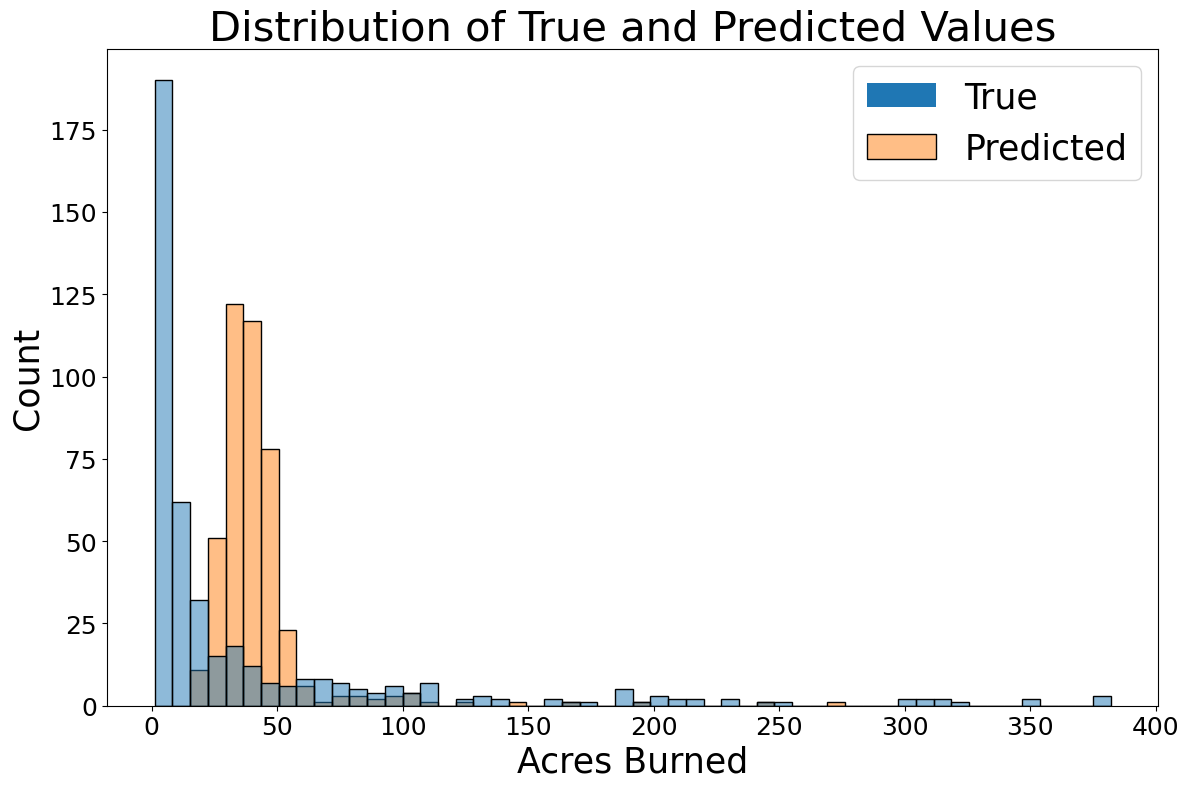

In [190]:
plt.figure(figsize = (12,8))
sns.histplot(data = test_df[['total_acres', 'predicted']])
plt.title('Distribution of True and Predicted Values', fontsize = 30)
plt.xlabel('Acres Burned', fontsize = 25)
plt.xticks(fontsize = 18)
plt.ylabel('Count', fontsize = 25)
plt.yticks(fontsize = 18)
plt.legend(['True', 'Predicted'], fontsize = 25)
plt.tight_layout();
plt.savefig('../../public/visuals/True_vs_Preds.png')

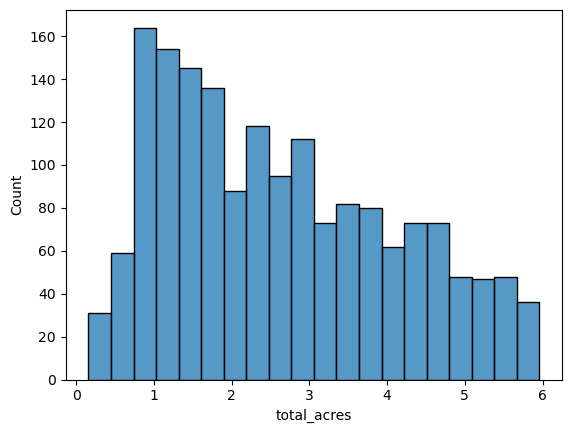

In [166]:
# Visualizing the log of the target to see if that was worth investigating

sns.histplot(data = np.log(df['total_acres']), bins = 20);

## The post-model analysis shows the best model (stack1) cannot predict low values, resulting in the RMSE not being as low as we had hoped. Moreover, the log of the target isn't normally distributed, but would be worth further investigatino in the future